In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

# Load Dataset

In [94]:
dataset = pd.read_csv('data\weather_dataset.csv', index_col='date', parse_dates=True)

In [95]:
dataset.head()

,Ttb,Tx,Tn,R,Utb,Un,wind
date,,,,,,,
2015-01-01,14.7,25.3,9.3,NaN,75.0,33.0,2.0
2015-01-02,13.9,23.5,7.5,NaN,75.8,37.0,4.0
2015-01-03,14.1,21.0,9.5,NaN,83.5,54.0,4.0
2015-01-04,16.5,18.8,14.6,NaN,88.3,83.0,2.0
2015-01-05,19.0,22.6,16.5,0.0,87.0,72.0,2.0


In [96]:
dataset.tail()

,Ttb,Tx,Tn,R,Utb,Un,wind
date,,,,,,,
2020-12-27,20.3,24.8,17.3,NaN,83.0,67.0,NaN
2020-12-28,20.7,23.6,18.8,NaN,88.0,77.0,1.0
2020-12-29,21.4,25.8,19.9,NaN,86.0,74.0,2.0
2020-12-30,17.5,20.9,16.2,NaN,50.0,42.0,6.0
2020-12-31,13.6,19.0,12.1,NaN,57.0,41.0,6.0


# Data Preprocessing

In [97]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2192 entries, 2015-01-01 to 2020-12-31
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Ttb     2192 non-null   float64
 1   Tx      2192 non-null   float64
 2   Tn      2192 non-null   float64
 3   R       988 non-null    float64
 4   Utb     2192 non-null   float64
 5   Un      2192 non-null   float64
 6   wind    1764 non-null   float64
dtypes: float64(7)
memory usage: 137.0 KB


### Replace missing values

In [98]:
dataset.isna().sum()

Ttb        0
Tx         0
Tn         0
R       1204
Utb        0
Un         0
wind     428
dtype: int64

In [99]:
dataset = dataset.fillna(0.0)

In [100]:
dataset.isna().sum()

Ttb     0
Tx      0
Tn      0
R       0
Utb     0
Un      0
wind    0
dtype: int64

### Scaling dataset

In [101]:
from sklearn.preprocessing import MinMaxScaler

In [102]:
scaler = MinMaxScaler()
dataset_scaled = scaler.fit_transform(dataset)

In [103]:
len(dataset_scaled)

2192

# Splitting Dataset

In [104]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [105]:

data_train = dataset_scaled[:2030].reshape((len(dataset[:2030]), len(dataset.columns)))
data_test = dataset_scaled[2000:].reshape((len(dataset[2000:]), len(dataset.columns)))

n_input = 30
generator_train = TimeseriesGenerator(data=data_train, targets=data_train, length=n_input, batch_size=1)
generator_test = TimeseriesGenerator(data=data_test, targets=data_test, length=n_input, batch_size=1)

print(len(generator_train), len(generator_test))

2000 162


In [106]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

In [107]:
n_features = 7
model = Sequential()
model.add(LSTM(units=50, activation='tanh', input_shape=(n_input, n_features)))
model.add(RepeatVector(1))
model.add(LSTM(units=50, activation='tanh', return_sequences=True))
model.add(TimeDistributed(Dense(7)))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 50)                11600     
                                                                 
 repeat_vector_3 (RepeatVect  (None, 1, 50)            0         
 or)                                                             
                                                                 
 lstm_9 (LSTM)               (None, 1, 50)             20200     
                                                                 
 time_distributed_3 (TimeDis  (None, 1, 7)             357       
 tributed)                                                       
                                                                 
Total params: 32,157
Trainable params: 32,157
Non-trainable params: 0
_________________________________________________________________


In [108]:
model.fit(generator_train, epochs = 10, verbose =1)

Epoch 1/10
2000/2000 [==============================] - 19s 8ms/step - loss: 0.0140
Epoch 2/10
2000/2000 [==============================] - 17s 8ms/step - loss: 0.0083
Epoch 3/10
2000/2000 [==============================] - 17s 8ms/step - loss: 0.0076
Epoch 4/10
2000/2000 [==============================] - 17s 8ms/step - loss: 0.0074
Epoch 5/10
2000/2000 [==============================] - 17s 8ms/step - loss: 0.0073
Epoch 6/10
2000/2000 [==============================] - 17s 8ms/step - loss: 0.0071
Epoch 7/10
2000/2000 [==============================] - 16s 8ms/step - loss: 0.0071
Epoch 8/10
2000/2000 [==============================] - 17s 8ms/step - loss: 0.0070
Epoch 9/10
2000/2000 [==============================] - 17s 8ms/step - loss: 0.0068
Epoch 10/10
2000/2000 [==============================] - 17s 9ms/step - loss: 0.0069


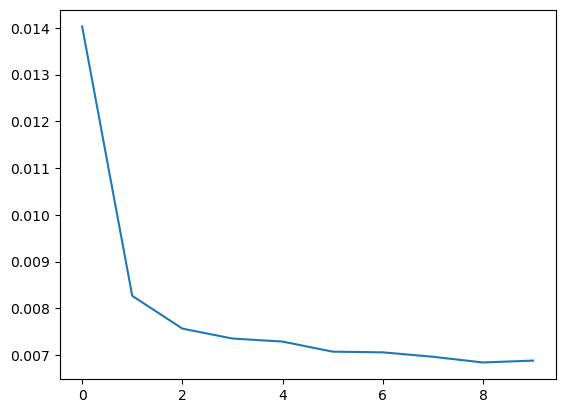

In [110]:
plt.plot(model.history.history['loss'])

# Test

In [151]:

y_predict, y_true = [], []

for i in range(len(generator_test)):
    
    X_test_i, y_true_i = generator_test[i]
    
    y_true.append(y_true_i)
    y_predict.append(model.predict(X_test_i))

y_true = np.array(y_true)
y_predict = np.array(y_predict)



1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 19ms/step


In [158]:
Ttb, Tx, Tn, R, Utb, Un, wind = [], [], [], [], [], [], []
for element in y_predict:
    Ttb.append(element[0][0][0])
    Tx.append(element[0][0][1])
    Tn.append(element[0][0][2])
    R.append(element[0][0][3])
    Utb.append(element[0][0][4])
    Un.append(element[0][0][5])
    wind.append(element[0][0][6])

# Evaluating

### Ttb (Mean Temperature)

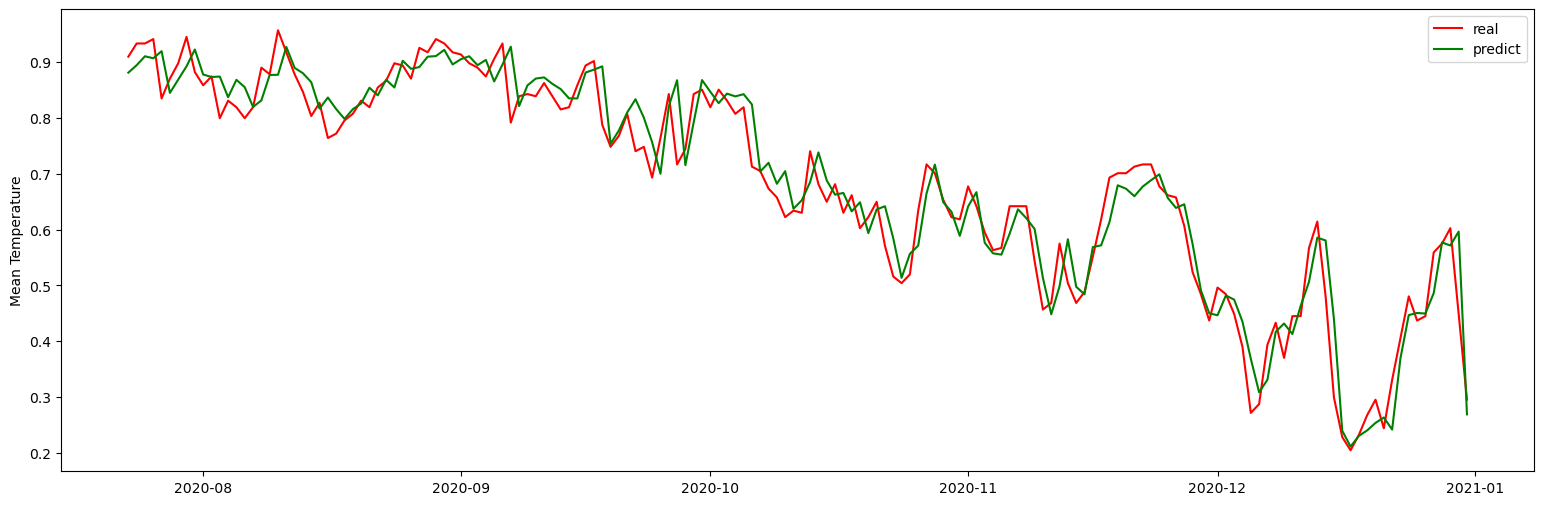

In [164]:
plt.figure(figsize=(19,6))
plt.plot(dataset[2030:].index, y_true[:,0,0], c='red', label='real')
plt.plot(dataset[2030:].index, Ttb, c='green', label='predict')
plt.legend()
plt.ylabel('Mean Temperature');

### Tx (Max Temperature)

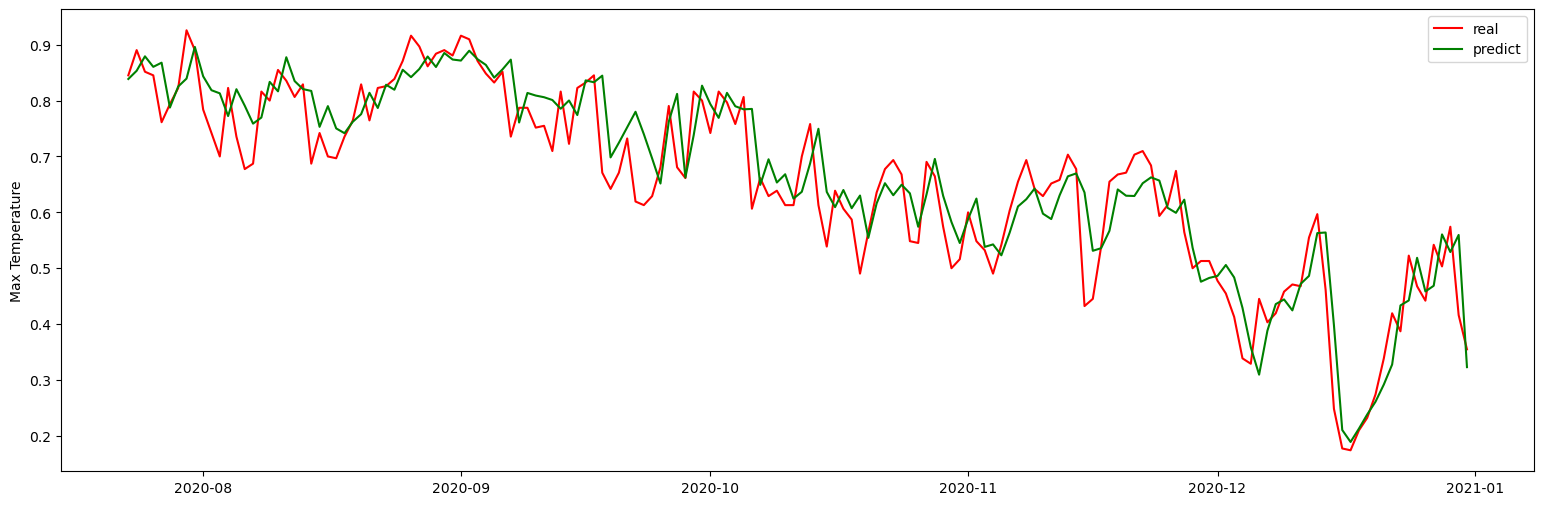

In [165]:
plt.figure(figsize=(19,6))
plt.plot(dataset[2030:].index, y_true[:,0,1], c='red', label='real')
plt.plot(dataset[2030:].index, Tx, c='green', label='predict')
plt.legend()
plt.ylabel('Max Temperature');

### Tn (Min Temperature)

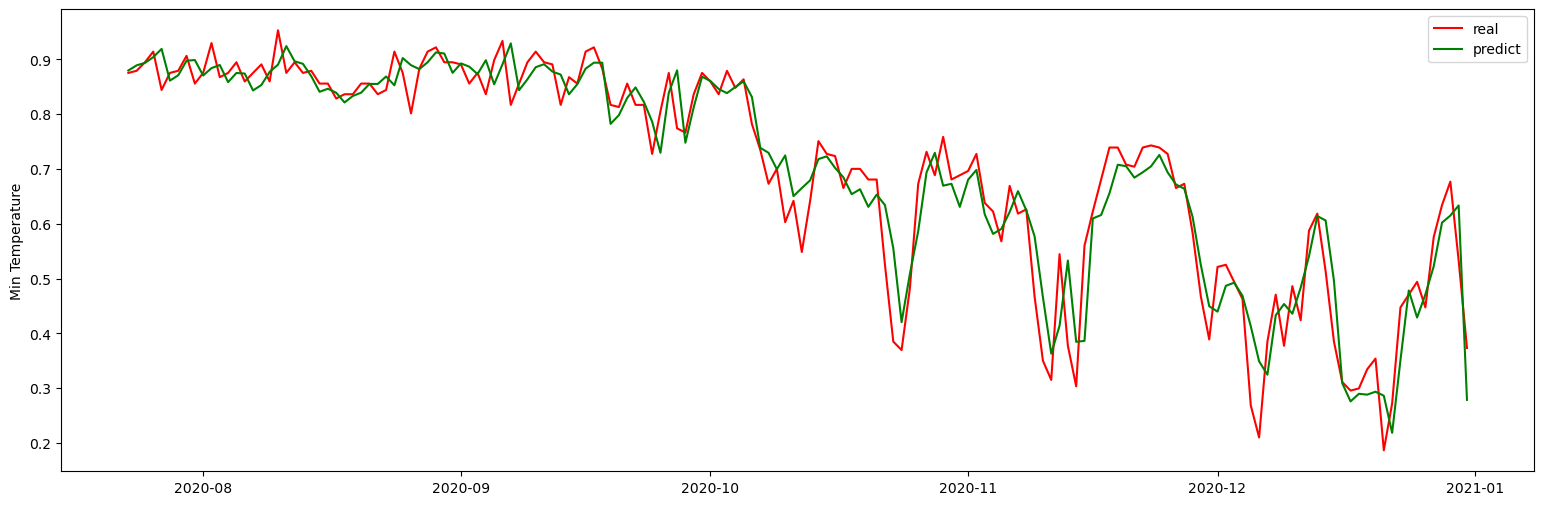

In [166]:
plt.figure(figsize=(19,6))
plt.plot(dataset[2030:].index, y_true[:,0,2], c='red', label='real')
plt.plot(dataset[2030:].index, Tn, c='green', label='predict')
plt.legend()
plt.ylabel('Min Temperature');

### R (Rain)

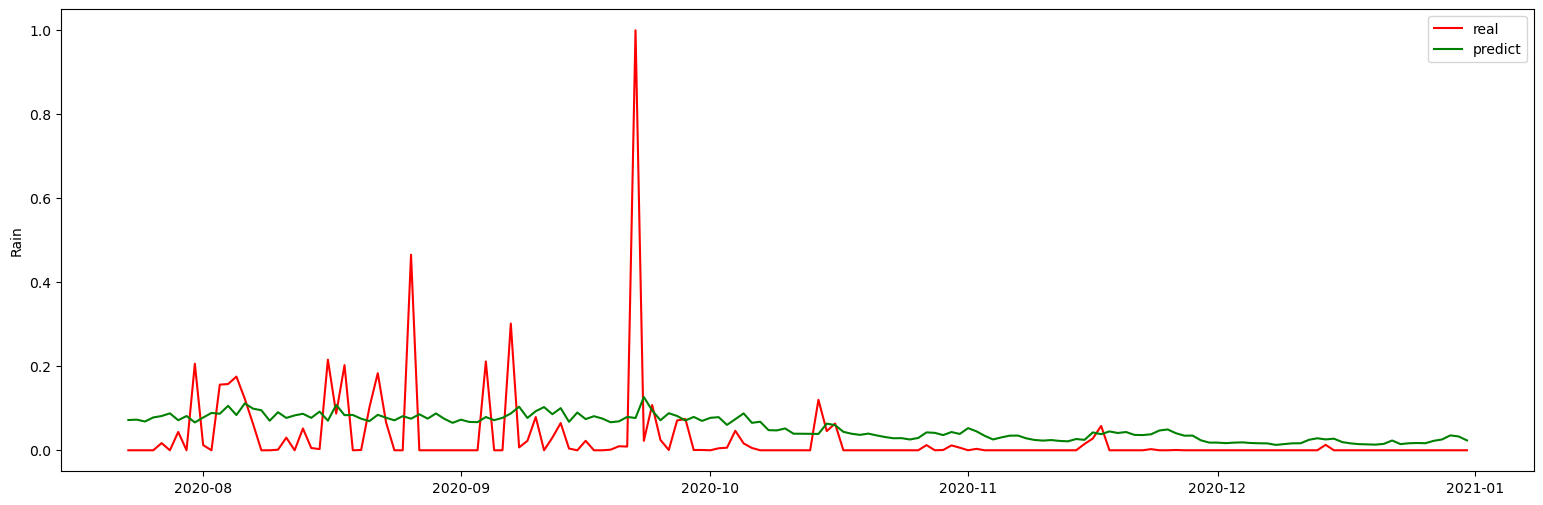

In [167]:
plt.figure(figsize=(19,6))
plt.plot(dataset[2030:].index, y_true[:,0,3], c='red', label='real')
plt.plot(dataset[2030:].index, R, c='green', label='predict')
plt.legend()
plt.ylabel('Rain');

### Utb (Mean Humidity)

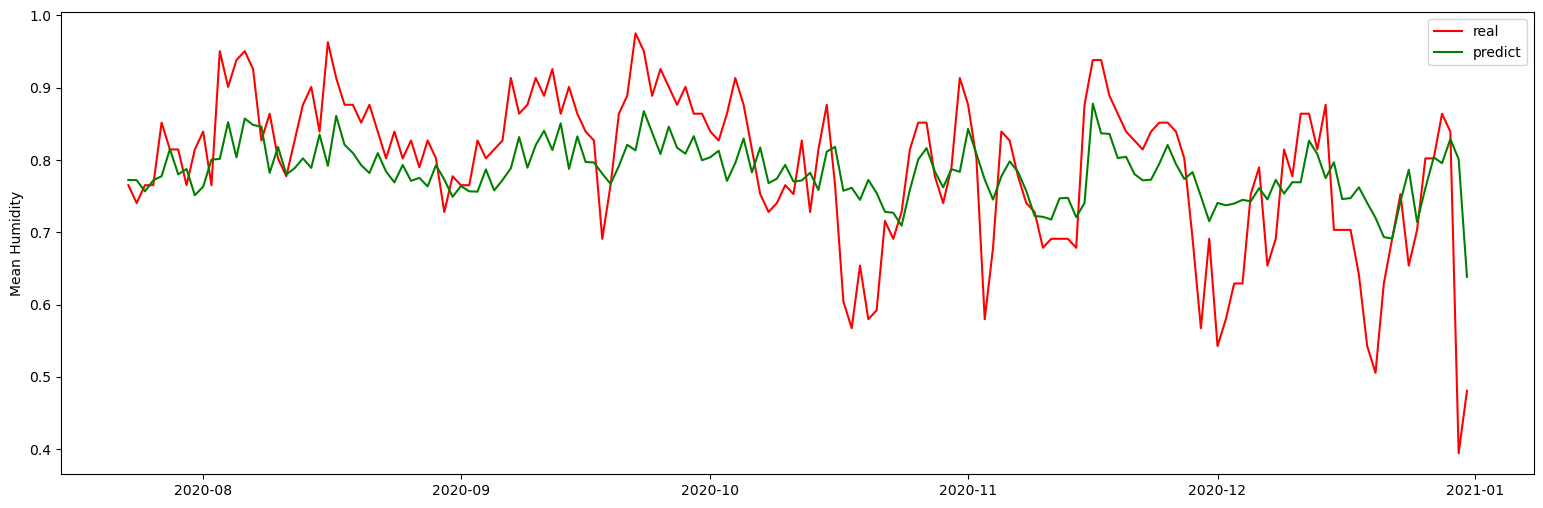

In [169]:
plt.figure(figsize=(19,6))
plt.plot(dataset[2030:].index, y_true[:,0,4], c='red', label='real')
plt.plot(dataset[2030:].index, Utb, c='green', label='predict')
plt.legend()
plt.ylabel('Mean Humidity');

### Un (Min Humidity)

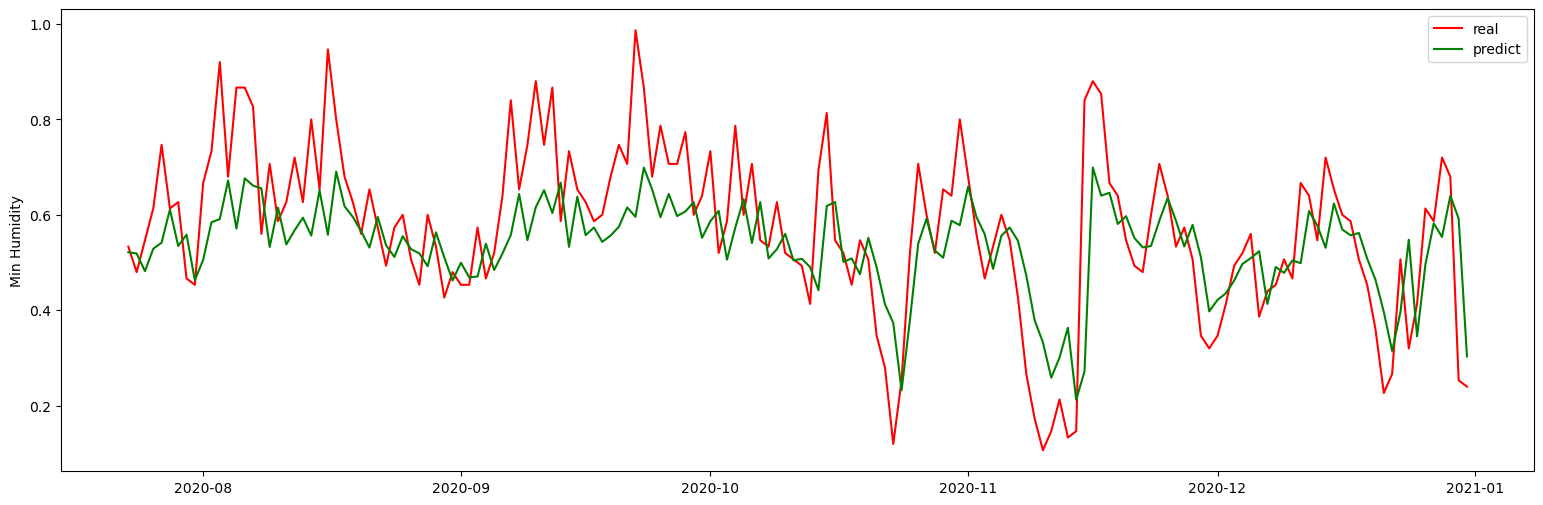

In [170]:
plt.figure(figsize=(19,6))
plt.plot(dataset[2030:].index, y_true[:,0,5], c='red', label='real')
plt.plot(dataset[2030:].index, Un, c='green', label='predict')
plt.legend()
plt.ylabel('Min Humidity');

### wind

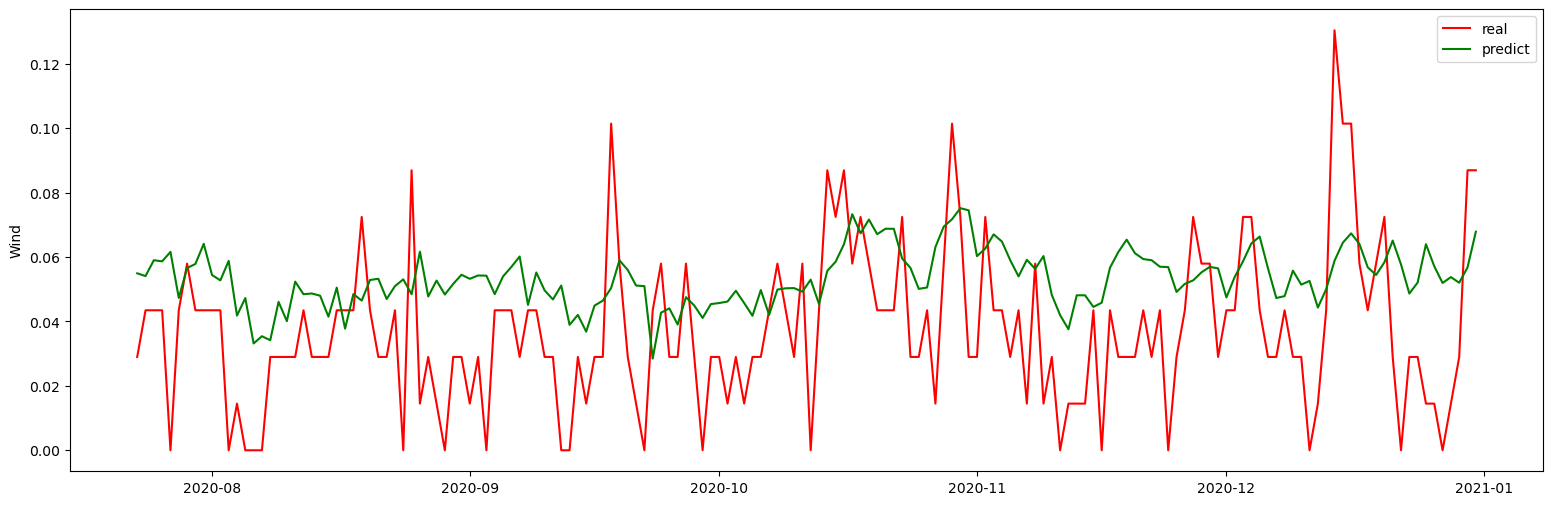

In [168]:
plt.figure(figsize=(19,6))
plt.plot(dataset[2030:].index, y_true[:,0,6], c='red', label='real')
plt.plot(dataset[2030:].index, wind, c='green', label='predict')
plt.legend()
plt.ylabel('Wind');